In [12]:
%load_ext autoreload
%autoreload 2

from collections import OrderedDict

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from respy_smm.MaximumLikelihoodEstimation import MaximumLikelihoodEstimationCls
from respy_smm.SimulationBasedEstimation import SimulationBasedEstimationCls
from respy_smm.optimizers.auxiliary_pybobyqa import wrapper_pybobyqa
from respy_smm.auxiliary_depreciation import respy_obj_from_new_init
from respy_smm.optimizers.auxiliary_pybobyqa import get_box_bounds
from respy.pre_processing.data_processing import process_dataset

from respy_smm.tests.auxiliary import get_observed_sample

def plot_criterion_function(rslt):
    fig, ax = plt.subplots(1, 1)
    ax.plot(rslt["fval"])
    ax.set_title('Criterion function during optimization')
    ax.set_ylabel('Criterion function')
    ax.set_xlabel('Evaluation')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

def plot_selected_parameter(rslt, pos):
    fig, ax = plt.subplots(1, 1)
    ax.plot(rslt["x_econ_all"][:, pos])
    ax.set_title('Parameter during optimization')
    ax.set_ylabel('Parameter {:}'.format(pos))
    ax.set_xlabel('Evaluation')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
fname = 'truth.respy.ini'
respy_obj = respy_obj_from_new_init(fname)
df = get_observed_sample(fname)
df.head()

Identifier  Period  Choice          Wage  Experience_A  \
Identifier Period                                                           
0          0                0       0       3           NaN             0   
           1                0       1       2  1.909853e+06             0   
           2                0       2       3           NaN             0   
           3                0       3       3           NaN             0   
           4                0       4       3           NaN             0   

                   Experience_B  Years_Schooling  Lagged_Choice  Type  \
Identifier Period                                                       
0          0                  0                7              3     0   
           1                  0                8              3     0   
           2                  1                8              2     0   
           3                  1                9              3     0   
           4                  1               10              3     0   

                   Total_Reward_1         ...          Shock_Reward_3  \
Identifier Period                         ...                           
0          0         1.543243e+06         ...                0.682802   
           1         1.352703e+06         ...                0.353985   
           2         9.923047e+05         ...                0.268624   
           3         4.390555e+05         ...                1.936420   
           4         2.093751e+05         ...               -0.818065   

                   Shock_Reward_4  Discount_Rate  General_Reward_1  \
Identifier Period                                                    
0          0             1.921379           0.95               0.0   
           1            -1.409555           0.95               0.0   
           2            -1.178800           0.95               0.0   
           3             0.805273           0.95               0.0   
           4            -0.851305           0.95               0.0   

                   General_Reward_2  Common_Reward  Immediate_Reward_1  \
Identifier Period                                                        
0          0                    0.0            0.0        88666.411322   
           1                    0.0            0.0       254829.727842   
           2                    0.0            0.0       245524.915120   
           3                    0.0            0.0        50859.169246   
           4                    0.0            0.0       209375.061505   

                   Immediate_Reward_2  Immediate_Reward_3  Immediate_Reward_4  
Identifier Period                                                              
0          0             1.527807e+05       300000.682802       150001.921379  
           1             1.909853e+06       300000.353985       149998.590445  
           2             6.436165e+04       300000.268624       149998.821200  
           3             1.404823e+05       300001.936420       150000.805273  
           4             1.203472e+05       299999.181935       149999.148695  

[5 rows x 29 columns]

# Maximum likelihood estimation

We establish the baseline.

In [3]:
mle_truth = MaximumLikelihoodEstimationCls(*('truth.respy.ini', 200)).fval['start']
print(' ... value of MLE criterion function at truth {:10.5f}'.format(mle_truth))

 ... value of MLE criterion function at truth    5.29101


Now we are ready to start the estimation.

In [10]:
init_file, max_evals = 'model.respy.ini', 20

mle_obj = MaximumLikelihoodEstimationCls(*(init_file, max_evals))
box = get_box_bounds(init_file)

kwargs = dict()
kwargs['scaling_within_bounds'] = True
kwargs['bounds'] = (box[:, 0], box[:, 1])
kwargs['objfun_has_noise'] = True
kwargs['maxfun'] = 10e6

rslt = wrapper_pybobyqa(mle_obj.evaluate, mle_obj.x_free_econ_start, **kwargs)

We are not ready to inspect the quality of our optimization.

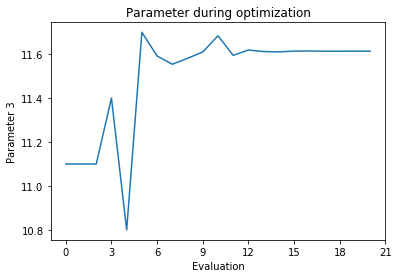

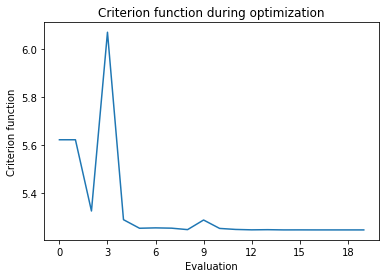

In [11]:
plot_selected_parameter(rslt, 3)
plot_criterion_function(rslt)

# Simulated method of moments

In [14]:
def get_moments(df):
    
    moments = OrderedDict()
    moments['Choice Probability'] = OrderedDict()
    info = df['Choice'].groupby('Period').value_counts(normalize=True).to_dict()
    for period in sorted(df['Period'].unique().tolist()):
        moments['Choice Probability'][period] = []
        for choice in range(1, 5):
            try:
                stat = info[(period, choice)]
            except KeyError:
                stat = 0.00
            moments['Choice Probability'][period].append(stat)
    return moments

weighing_matrix = np.identity(4 * 5)
moments_obs = get_moments(df)

We establish a baseline.

In [7]:
args = ('truth.respy.ini', moments_obs, weighing_matrix, get_moments, max_evals)
smm_truth = SimulationBasedEstimationCls(*args).fval['start']
print(' ... value of SMM criterion function at truth {:10.5f}'.format(smm_truth))

 ... value of SMM criterion function at truth    0.00000


In [8]:
init_file, max_evals = 'model.respy.ini', 200

args = (init_file, moments_obs, weighing_matrix, get_moments, max_evals)
smm_obj = SimulationBasedEstimationCls(*args)

kwargs = dict()
kwargs['scaling_within_bounds'] = True
kwargs['bounds'] = (box[:, 0], box[:, 1])
kwargs['objfun_has_noise'] = True
kwargs['maxfun'] = 10e6

rslt = wrapper_pybobyqa(smm_obj.evaluate, smm_obj.x_free_econ_start, **kwargs)

We can now look at the progress of the optimization over time.

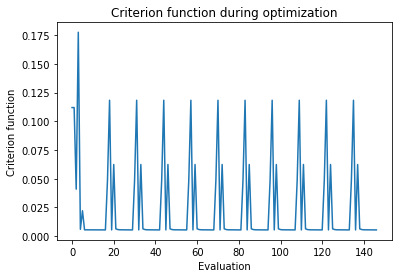

In [9]:
plot_criterion_function(rslt)